In [ ]:
# default_exp engine.microscope

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Microscope model

> Definition of the classes and functions we use to generate recordings given network outputs or simulations

ToDo: 
* Currently only supports color shifts for data with 2 colors
* Currently hard coded to sit on the gpu

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
import torch.nn as nn
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.engine.place_psfs import CudaPlaceROI

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
#export
class Microscope(nn.Module):
    """
    The Mircoscope module takes 5 vectors 'locations', 'x_os', 'y_os', 'z_os',
    'ints_3d' and the outputshape and turns them into 3D data through the following steps:
    1) Select the right PSF according to color
    2) Apply continuous shifts to the PSF according to x_os, y_os, z_os
    3) Clamping the PSF (retaining only positive values)
    4) Normalize the PSF (if set to do so)
    5) Scales PSFs by intensities
    6) Place point spread function according to locations
    7) Multiply resulting image by scale

    Args:
        psf (torch.nn.Module): Parametric PSF
        noise (torch.nn.Module): Camera noise model
        scale (float): Constant for scaling 
        slice_rec (bool): Whether the data is 1-dimensional in z (i.e. slices)
        ch_facs (torch.tensor or None): scaling factor for each channel (used to normalize real data inputs). if None is initialize to 1
        ch_cols (torch.tensor or None): Tensor that indicates the color of each channel.
        col_shifts_enabled (bool): Whether we learn and apply a map that stores chromatic abberations between colors
        col_shifts_yxds (tuple): size of the FOVs, and the downsampling factor used for the chrom. abberation map. e.g. [2048, 2048, 50] 
        
    Shape:
        -Input: locations: Tuple(torch.Tensor)
                x_os_val: (N_emitters,)
                y_os_val: (N_emitters,)
                z_os_val: (N_emitters,)
                ints_val: (N_emitters,C)
                output_shape: Shape Tuple(BS, C, D, H, W)

        -Output: xsim: (BS, C, D, H, W)
    """


    def __init__(self, psf, noise, scale = 10000., norm='none', psf_noise=0, slice_rec=False, ch_facs=None, ch_cols=None, col_shifts_enabled=False, col_shifts_yxds=None):

        super().__init__()
        
        self.psf = psf
        self.psf_init_vol = psf.psf_volume.detach().to('cuda')
        self.psf_z_size = self.psf.psf_volume.shape[-3]
        
        self.scale = scale
        self.noise = noise
        self.norm = norm
        self.psf_noise = psf_noise
        self.slice_rec = slice_rec
        self.ch_cols = ch_cols
        
        if self.psf.n_cols > 1: assert self.ch_cols is not None, f"ch_cols cannot be None for n_cols > 1"
        if self.ch_cols is not None: assert self.psf.n_cols > 1, f"ch_cols contains {max(self.ch_cols) + 1} colors but the psf has {self.psf.n_cols} colors"
        
        self.theta = self.noise.theta_scale * self.noise.theta_par
        
        self.col_shifts_enabled = col_shifts_enabled
        if col_shifts_enabled:
            
            assert self.psf.n_cols > 1, f"col_shifts_enabled but n_cols = 0"
            
            self.col_shifts_yx = col_shifts_yxds[:2]
            self.col_shift_ds = col_shifts_yxds[2]   
        
            xs = int(np.ceil(self.col_shifts_yx[0]/self.col_shift_ds))
            ys = int(np.ceil(self.col_shifts_yx[1]/self.col_shift_ds))

            self.register_parameter(name='color_shifts', param=torch.nn.Parameter(torch.zeros([self.psf.n_cols, ys, xs])))
        
        self.register_parameter(name='channel_shifts', param=torch.nn.Parameter(torch.zeros((int(self.noise.channels/self.psf.n_cols), 3))))
        self.ch_scale = 1. if ch_facs is None else torch.tensor(ch_facs).cuda()
        self.register_parameter(name='channel_facs', param=torch.nn.Parameter(torch.ones(int(self.noise.channels)).cuda()))
        self.register_parameter(name='z_facs', param=self.psf.z_scale)
        self.register_parameter(name='sc_fac', param=torch.nn.Parameter(torch.ones(1).cuda()))    
        self.register_parameter(name='theta_par', param=self.noise.theta_par)
        
    def get_ch_mult(self):
        ''' Returns multiplicative factors to scale a 5D volume across the channel dimension '''
        return (self.channel_facs * self.ch_scale)[None,:,None,None,None]
    
    def add_psf_noise(self, psf_stack):
        '''Adds Gaussian noise to the psf. Idea is that this makes the network less sensitive to mismatch in the PSF. 
        Was usefull once but seems to not be needed anymore'''
        noise = torch.distributions.Normal(loc=0, scale=self.psf_noise).sample(psf_stack.shape).to(psf_stack.device)
        noise *= torch.sqrt(psf_stack)

        return psf_stack + noise
    
    def apply_channel_shifts(self, ch_inds, x_os_val, y_os_val, z_os_val):
        '''Applies round (! not color) dependent shifts '''
        shifts = self.channel_shifts - self.channel_shifts.mean(0)[None]

        if self.psf.n_cols > 1:
            multi_col_shifts = torch.zeros([self.noise.channels, 3]).to(shifts.device)
            for i in range(self.psf.n_cols):
                multi_col_shifts[torch.tensor(self.ch_cols)==i,:] = shifts
        else:
            multi_col_shifts = shifts

        x_os_val = x_os_val[ch_inds[0]] + multi_col_shifts[ch_inds[1], 0] 
        y_os_val = y_os_val[ch_inds[0]] + multi_col_shifts[ch_inds[1], 1]
        
        ''' Can't get optimization to work for some reason. look into it '''
        z_os_val = z_os_val[ch_inds[0]] # + multi_col_shifts[ch_inds[1], 2]
        
        return x_os_val, y_os_val, z_os_val
    
    def apply_color_shifts(self, ch_inds, locations, x_os_val, y_os_val, ycrop, xcrop):
        '''Apply color dependent shifts'''
        
        # Select the color inds assigned to each channel
        col_inds = torch.tensor(self.ch_cols)[ch_inds[1]]
        
        # We blur the colorshift map to obtain smooth results
        blurred_col_shift = kornia.filters.gaussian_blur2d(self.color_shifts[None],  (9,9), (3,3))[0]

        # Select the right element from the downsampled shift map for each emitter
        col_shifts = blurred_col_shift[:, torch.div(locations[2][ch_inds[0]] + ycrop.cuda()[locations[0]], self.col_shift_ds, rounding_mode='trunc'), 
                                          torch.div(locations[3][ch_inds[0]] + xcrop.cuda()[locations[0]], self.col_shift_ds, rounding_mode='trunc')]

        # Shift emitters in color channel 1
        x_os_val[col_inds==1] = x_os_val[col_inds==1] + col_shifts[0, col_inds==1]
        y_os_val[col_inds==1] = y_os_val[col_inds==1] + col_shifts[1, col_inds==1]
        
        return x_os_val, y_os_val

    def get_single_ch_inputs(self, locations, x_os_val, y_os_val, z_os_val, i_val, output_shape=None, ycrop=None, xcrop=None):
        '''Transforms outputs from the network or the pointprocess sampler where each emitter has N_channel intensities and one xyz position
        into the single channel represenation (one intensity and a channel index) which the microscope uses.
        
        Also applies round and color shifts.
        '''
        
        # Identify channels by looking for nonzero intensities
        ch_inds = i_val.nonzero(as_tuple=True)

        if len(ch_inds[1]):
            if ch_inds[1].max() > 0:

                i_val = i_val[ch_inds]

                locations = [l[ch_inds[0]] for l in locations]
                locations.insert(1,ch_inds[1])   

                x_os_val, y_os_val, z_os_val = self.apply_channel_shifts(ch_inds, x_os_val, y_os_val, z_os_val)
                
                if self.col_shifts_enabled and ycrop is not None:

                    x_os_val, y_os_val = self.apply_color_shifts(ch_inds, locations, x_os_val, y_os_val, ycrop, xcrop)

        else:
            locations.insert(1,locations[0]) 

        return locations, x_os_val, y_os_val, z_os_val, i_val, output_shape
    
    def forward(self, locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, ret_psfs=False, add_noise=False):
        '''Locations contains indices for Batch, Channel, Z, Y, X'''
        if len(locations[0]):
            # If multi color get the right color indices dendent on channel indices
            col_inds=torch.tensor(self.ch_cols)[locations[1]] if self.ch_cols is not None else None

            if self.slice_rec and self.psf_z_size > 1:
                # If we do slice rec z_os_ch which has a range of [-1,1] (from simulations or network output) is turned into an index for a slice from the psf_volume and a continuous offset 
                z_os_ch = torch.clamp(0.5*z_os_ch,-0.49999,0.49999) + 0.5 # transform to [0,1]
                z_scaled = z_os_ch * (self.psf_z_size - 2) # [0, z_size]
                z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
                z_os = -(torch.fmod(z_scaled, 1.)) + 0.5

                psf = self.psf(x_os_ch, y_os_ch, z_os, z_inds, c_inds=col_inds)
                
            else:
                # Otherwise z_os_ch is treated just as x and y    
                psf = self.psf(x_os_ch, y_os_ch, z_os_ch, c_inds=col_inds)
                z_inds = None

            if self.norm == 'escort':
                psf = torch.abs(psf)
                if self.slice_rec:
                    # normalize each slice individually
                    psf = psf/psf.flatten(-2,-1).sum(-1)[...,None,None]
                else:
                    psf = psf/psf.sum()
            else:
                torch.clamp_min_(psf,0)
        
            if self.psf_noise and add_noise: 
                psf = self.add_psf_noise(psf)

            tot_intensity = torch.clamp_min(i_val, 0)  
    
            psf_sc = psf * tot_intensity[:,None,None,None,None]
            
            if ret_psfs:
                # Don't place the psfs and instead return the PSF volumes. Used for ROI based gen. model learning
                return self.sc_fac * self.scale * psf_sc
            
            # place psf according to locations
            xsim = place_psf(locations, psf_sc, output_shape)
            
            # scale using the initial parameter and a learned factor
            xsim = self.sc_fac * self.scale * xsim
            
            return xsim
        
        else:
            
            return torch.zeros(output_shape).cuda()

In [ ]:
#export
def place_psf(locations, psf_volume, output_shape):
    """
    Places point spread functions (psf_volume) in to corresponding locations.

    Args:
        locations: tuple with the 5D voxel coordinates
        psf_volume: torch.Tensor
        output_shape: Shape Tuple(BS, C, H, W, D) 

    Returns:
        placed_psf: torch.Tensor with shape (BS, C, H, W, D)
    """

    b, c, z, y, x = locations
    # Deprecated python loop
#     placed_psf = _place_psf(psf_volume, b, c, z, y, x, torch.tensor(output_shape))
    
    # New fancy cuda loop
    N_psfs, _, psf_s_z, psf_s_y, psf_s_x = psf_volume.shape   
    placed_psf = CudaPlaceROI.apply(psf_volume[:,0], output_shape[0], output_shape[1], output_shape[2], output_shape[3], output_shape[4], N_psfs, psf_s_z, psf_s_y, psf_s_x, b, c, z-psf_s_z//2, y-psf_s_y//2, x-psf_s_x//2)
    
    assert placed_psf.shape == output_shape
    return placed_psf

def extract_psf_roi(locations, x_vol, roi_shape):
    """
    Extract ROIs from a given volume
    """
    
    batch, ch, z, y, x = locations 
    rois = _extract_psf_roi(x_vol, batch, ch, z, y, x, roi_shape)
    
    return rois

from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

def get_roi_filt_inds(batch, ch, z, y, x, psf_shape, vol_shape, min_dist=None, slice_rec=False):
    """
    Filter locations that are used for gen. model training.
    Returns remaining indices.
    """
    
    inds = torch.arange(len(x))
    
    if min_dist:
        # scale z if slice_rec ?? 
        # Scale catch and channel such that only emitter in the same b/ch are considered close
        bczyx = np.stack([cpu(batch)*1000,cpu(ch)*1000,cpu(z),cpu(y),cpu(x)]).T
        tree = KDTree(bczyx)
        pairs = tree.query_pairs(r=min_dist, output_type='ndarray')
        pair_inds = np.unique(pairs.reshape(-1))
        
    psf_d, psf_h, psf_w = psf_shape[-3:]
    vol_d, vol_h, vol_w = vol_shape[-3:]
    # Filter locs at the edges
    cond = (x > psf_w//2) & (x < vol_w - psf_w//2)
    cond*= (y > psf_h//2) & (y < vol_h - psf_h//2)
    if not slice_rec:
        cond*= (z > psf_d//2) & (z < vol_d - psf_d)   
        
    if min_dist:
        return np.setdiff1d(inds[cond], pair_inds, assume_unique=True)
    else:
        return inds[cond]
    
def mic_inp_apply_inds(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, inds):
    
    locations = [l[inds] for l in locations]
    return locations, x_os_ch[inds], y_os_ch[inds], z_os_ch[inds], i_val[inds], output_shape

def add_pos_noise(offset_vars, scales, n_bits, cond=None, rm_mean=True):
    """
    Add noise on the continuous positions. The noise values for the same transcript across n_bits channels have a 0 mean such that the network can actually infer the correct position.
    """

    # Get indices of emitters that belong to multi-channel code
    if cond is not None: 
        cb_inds = torch.repeat_interleave(cond, cond * (n_bits - 1) + 1)
        n_os = sum(cb_inds)
    else:
        n_os = len(offset_vars[0])
    
    for i in range(len(scales)):
        
        if scales[i] > 0:
    
            if rm_mean:
                noise = torch.distributions.Normal(loc=0, scale=scales[i]).sample([n_os]).to(offset_vars[i].device).reshape(-1, n_bits)
                noise -= noise.mean(-1, keepdim=True)
            else:
                noise = torch.distributions.Normal(loc=0, scale=scales[i]).sample([n_os]).to(offset_vars[i].device)
            
            if cond is not None: 
                offset_vars[i][cb_inds] = offset_vars[i][cb_inds] + noise.reshape(-1)
            else:
                offset_vars[i] = offset_vars[i] + noise.reshape(-1)

    return offset_vars

def concat_micro_inp(micro_inp_list, batch_size=1):
    locs = [torch.concat([o[0][0] + i*batch_size for i,o in enumerate(micro_inp_list)])]
    for k in range(1,4):
        locs += [torch.concat([o[0][k] for i,o in enumerate(micro_inp_list)])]
    ret_vars = [locs]
    # last element is output size
    for k in range(1, len(micro_inp_list[0]) - 1):
        ret_vars.append(torch.concat([o[k] for o in micro_inp_list]))
    out_len = len(micro_inp_list) * batch_size
    ret_vars.append(torch.Size([out_len] + list(micro_inp_list[0][-1][1:])))
    return tuple(ret_vars)

In [ ]:
#export
@script
def _extract_psf_roi(x_vol, batch, ch, z, y, x, roi_shape):
    
    """
    Extract rois. We assume that border conditions are dealt with already. 
    
    """

    psf_b, psf_ch, psf_d, psf_h, psf_w = roi_shape[0], roi_shape[1], roi_shape[2], roi_shape[3], roi_shape[4]
    roi_vol = torch.empty(psf_b, psf_ch, psf_d, psf_h, psf_w).to(x_vol.device)    
    pad_zyx = [torch.div(psf_d, 2, rounding_mode='trunc'), torch.div(psf_h, 2, rounding_mode='trunc'), torch.div(psf_w, 2, rounding_mode='trunc')]
    
    z_l = z - pad_zyx[0]
    y_l = y - pad_zyx[1]
    x_l = x - pad_zyx[2]
    
    z_h = z + pad_zyx[0] + 1
    y_h = y + pad_zyx[1] + 1
    x_h = x + pad_zyx[2] + 1
    
    for idx in range(x.shape[0]):

        roi_vol[idx] = x_vol[batch[idx], ch[idx],
                         z_l[idx] : z_h[idx],
                         y_l[idx] : y_h[idx],
                         x_l[idx] : x_h[idx]]
        
    return roi_vol

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.funcs.file_io import get_gaussian_psf
from decode_fish.funcs.file_io import get_vol_psf
from decode_fish.funcs.output_trafo import sample_to_df

psf = LinearInterpolatedPSF(load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf_07_20n.tif'), n_cols=2, mode='bicubic')

noise = sCMOS(channels=22)

n_bits = 4
ch_cols = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
micro = Microscope(psf=psf, noise=noise, scale=100, norm='none',  psf_noise=0.0, slice_rec=True, ch_cols=ch_cols).cuda()

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


In [ ]:
for name, p in micro.named_parameters():
    print(name, p.requires_grad)

channel_shifts True
channel_facs True
z_facs True
sc_fac True
theta_par True
psf.psf_volume True


In [ ]:
from decode_fish.funcs.exp_specific import *
codebook, targets = get_mop_codebook()
codebook_sim = np.concatenate([codebook, np.eye(22)], 0)
code_weight = torch.ones(len(codebook_sim))
code_weight[-22:] *= 3

In [ ]:
point_process = PointProcessUniform(int_conc=3, int_rate=1, int_loc=1, sim_iters=5, n_channels=22, sim_z=True, codebook=torch.tensor(codebook_sim, dtype=torch.bool), int_option=1, code_weight=code_weight)
local_rate = torch.ones([3,7,48,48]).cuda()*.002
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(local_rate=torch.ones([3,7,48,48]).cuda()*.002, from_code_book=True)
locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape = micro.get_single_ch_inputs(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

x_tra, y_tra, z_tra = x_os_ch+0, y_os_ch+0, z_os_ch+0

x_os_ch, y_os_ch, z_os_ch = add_pos_noise([x_os_ch, y_os_ch, z_os_ch], [0.1,0.1,0.02], 4, codes < len(codebook))
df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


In [ ]:
psfs = micro(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, add_noise=False, ret_psfs=True)

In [ ]:
xsim = micro(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, add_noise=True)

In [ ]:
filt_inds = get_roi_filt_inds(*locations, micro.psf.psf_volume.shape, xsim.shape, slice_rec=True, min_dist=13)
ch_out_inp = mic_inp_apply_inds(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, filt_inds)
psf_recs = micro(*ch_out_inp, ret_psfs=True, add_noise=False)  
rois = extract_psf_roi(ch_out_inp[0], xsim, torch.tensor(psf_recs.shape))

No handles with labels found to put in legend.


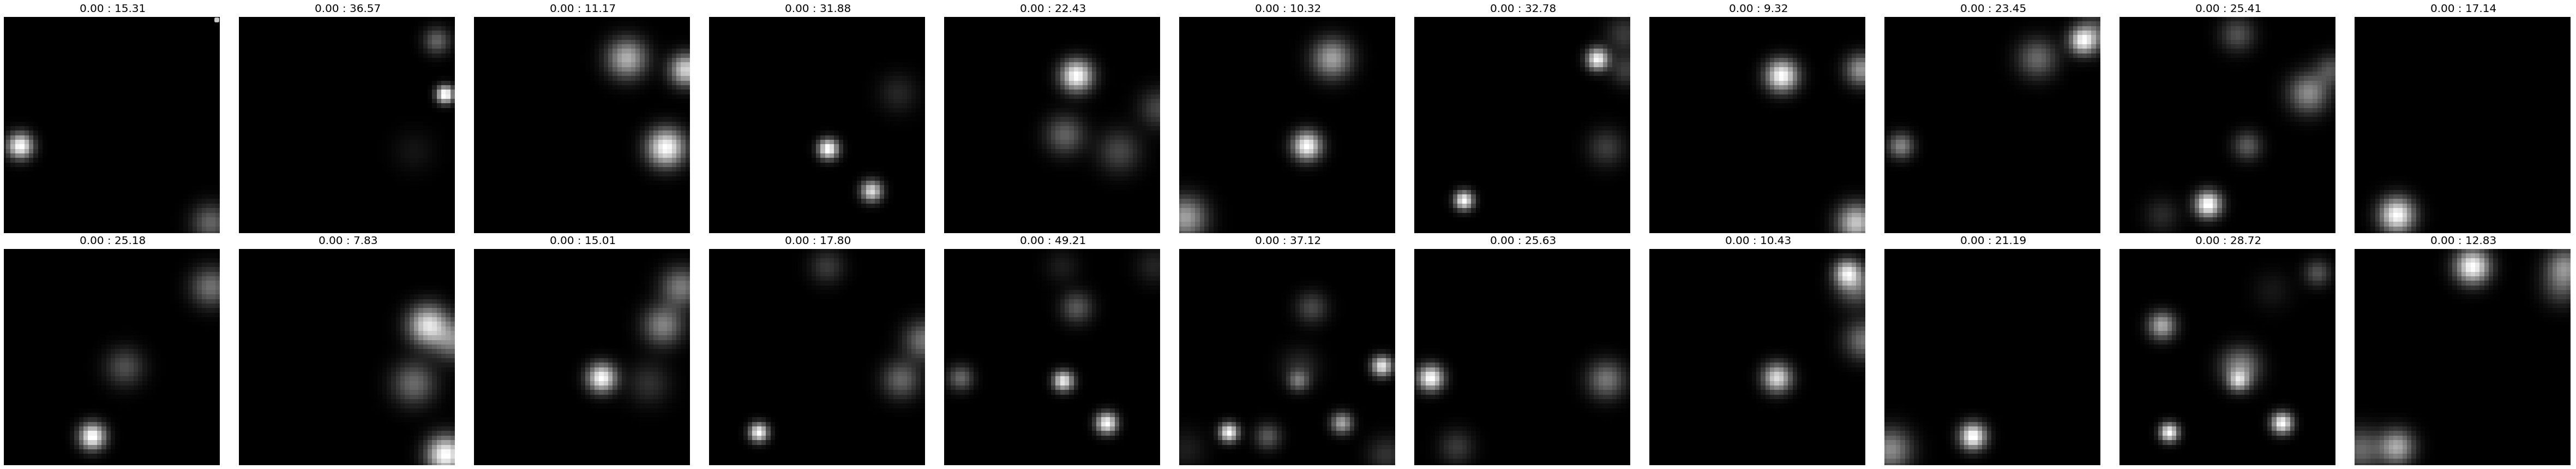

In [ ]:
from decode_fish.funcs.plotting import *
_ = plot_channels(xsim[0],2, proj_func=np.sum)

### check that 2D Z reconstruction is correct.

In [ ]:
local_rate = torch.zeros([100,7,11,11]).cuda()
local_rate[:,0,5,5] = 1.

point_process = PointProcessUniform(int_conc=3, int_rate=1, sim_iters=1, int_loc=1, n_channels=22,  codebook=torch.tensor(codebook)[:1], sim_z=True)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(local_rate=local_rate, from_code_book=True)
df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

x_os_3d *= 0 
y_os_3d *= 0 
ints_3d *= 0 
ints_3d += 1
z_os_3d = torch.linspace(-1.,1.,100).cuda()

ch_inp = micro.get_single_ch_inputs(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

psf_s = micro(*ch_inp, add_noise=False, ret_psfs=True)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


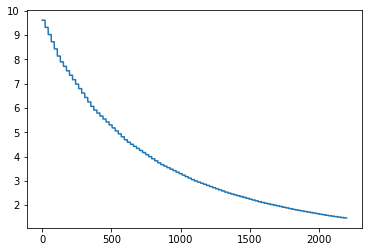

In [ ]:
plt.plot(cpu(psf_s)[:,0,0,10,10])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
